In [1]:
from subprocess import Popen, PIPE
import getpass
username='EZAGAYNAYA'
REALM='BEE.VIMPELCOM.RU'
password = getpass.getpass(prompt='Enter Your Ldap password:\n')
kinit = 'kinit'
kinit_args = [ kinit, '%s@%s' % (username, REALM) ]
kinit = Popen(kinit_args, stdin=PIPE, stdout=PIPE, stderr=PIPE)
kinit.stdin.write(bytearray(password + "\n", "ascii"))
kinit.stdin.flush()
kinit.wait()

Enter Your Ldap password:
 ········


0

In [2]:
from pyspark import SparkConf  # noqa: E402
from pyspark.sql import DataFrame as SparkDataFrame  # noqa: E402
from pyspark.sql import SparkSession  # noqa: E402
from pyspark.sql import functions as F  # noqa: E402
from pyspark.sql.functions import col, when, min, max, sum, mean, count, substring, countDistinct, last_day, concat_ws 
from pyspark.sql.types import StringType, LongType

SPARK_SETTINGS = [
    ('spark.yarn.queue', 'default'),
        ('spark.sql.sources.partitionOverwriteMode', 'dynamic'),
        ('hive.exec.dynamic.partition', 'true'),
        ('hive.exec.dynamic.partition.mode', 'nonstrict'),
        ('spark.default.parallelism', '400'),
        ('spark.driver.memory', '20G'),
        ('spark.driver.memoryOverhead', '2G'),
        ('spark.driver.cores', 4),
        ('spark.driver.maxResultSize', '150G'),
        ('spark.dynamicAllocation.enabled', 'false'),
        ('spark.dynamicAllocation.maxExecutors', 200),
        ('spark.executor.memory', '20G'),
        ('spark.executor.memoryOverhead', '4G'),
        ('spark.executor.cores', 6),
        ('spark.executor.instances', 10),
        ('spark.hadoop.mapreduce.input.fileinputformat.input.dir.recursive', 'true'),
        ('spark.hive.mapred.supports.subdirectories', 'true'),# драйвер (понадобится для чтения из RDBMS)
        ('spark.kryoserializer.buffer', '1000m'),
        ('spark.kryoserializer.buffer.max', '2000m'),
        ('spark.rpc.message.maxSize', 2000),
        ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
        ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
        ('spark.sql.shuffle.partitions', '400'),
        ('spark.driver.extraClassPath', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'), # драйвер (понадобится для чтения из RDBMS)
        ('spark.jars', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'),
        ("spark.sql.hive.convertMetastoreOrc", " false"),
        ('spark.app.name', 'SVFomenkov_testing_pipeline')
]

app_name = 'ZEM_spark_session'

conf = SparkConf().setAppName(app_name).setMaster('yarn').setAll(SPARK_SETTINGS)
spark = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel('ERROR')
spark.conf.set("spark.sql.hive.convertMetastoreOrc", " false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/28 15:14:30 WARN HiveConf: HiveConf of name hive.mapred.supports.subdirectories does not exist
25/10/28 15:14:34 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
from IPython.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

/tmp/ipykernel_209/3383840084.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### Pandas

In [4]:
import pandas as pd
import numpy as np
import scipy as sp

import pickle
import shap

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, datasets, linear_model, metrics

import seaborn as sns

import datetime as dt
from datetime import datetime
from datetime import date
import math

# TF-IDF:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['max', 'min', 'sum', 'datetime', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
df_trigg_MK_SOHO = spark.read.table('b2b_stg.df_churn_weekly_scoring_v04')

print('num_rows:', df_trigg_MK_SOHO.count())

num_rows: 1173744


In [6]:
df_trigg_MK_SOHO.printSchema()

root
 |-- subscriber_sk: long (nullable = true)
 |-- woe_calls_sum_ratio_mean_lag0_2_4: double (nullable = true)
 |-- woe_voice_min_2_HR_avg_ratio_mean_lag0_2_4: double (nullable = true)
 |-- woe_voice_min_1_HR_avg_ratio_mean_lag0_2_4: double (nullable = true)
 |-- woe_gprs_mb_3_HR_avg_relative_change_lag0_1: double (nullable = true)
 |-- woe_voice_min_1to2_HR_avg_relative_change_lag0_1: double (nullable = true)
 |-- preds_trig_model: double (nullable = true)
 |-- interp_woe_calls_sum_ratio_mean_lag0_2_4: string (nullable = true)
 |-- interp_woe_voice_min_2_HR_avg_ratio_mean_lag0_2_4: string (nullable = true)
 |-- interp_woe_voice_min_1_HR_avg_ratio_mean_lag0_2_4: string (nullable = true)
 |-- interp_woe_gprs_mb_3_HR_avg_relative_change_lag0_1: string (nullable = true)
 |-- interp_woe_voice_min_1to2_HR_avg_relative_change_lag0_1: string (nullable = true)
 |-- preds_trig_model_norm: double (nullable = true)
 |-- subscriber_num: string (nullable = true)
 |-- account_type_cd: integer (nul

In [7]:
# df_ML = spark.read.table('b2b_stg.df_churn_ML_score_week_42') 
df_ML = spark.read.table('b2b_stg.df_churn_ML_score_week_42_v2') 

print('num_rows:', df_ML.count())
df_ML.printSchema()

num_rows: 4855421
root
 |-- subscriber_sk: integer (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- gprs_mb_3_H_avg_gr30_sum: integer (nullable = true)
 |-- gprs_mb_3_H_avg: float (nullable = true)
 |-- voice_min_1_H_avg_gr30_sum: integer (nullable = true)
 |-- voice_min_1_R_avg: float (nullable = true)
 |-- voice_min_2_H_avg_gr30_sum: integer (nullable = true)
 |-- price_plan_type_max_Other: integer (nullable = true)
 |-- active_days_sum: float (nullable = true)
 |-- price_plan_type_max_Bundle: integer (nullable = true)
 |-- voice_min_2_H_avg: float (nullable = true)
 |-- voice_min_2_R_avg_gr30_sum: integer (nullable = true)
 |-- voice_min_1_H_avg: float (nullable = true)
 |-- good_days_sum: float (nullable = true)
 |-- accept_days_sum: float (nullable = true)
 |-- bad_days_sum: float (nullable = true)
 |-- voice_min_1_R_avg_gr30_sum: integer (nullable = true)
 |-- repr2q2025_max: float (nullable = true)
 |-- subs_market_cd_vip: float (nullable = true)
 |-- voice_mi

In [8]:
print('num_cols:', len(df_ML.columns))

num_cols: 29


In [9]:
26 + 3

29

In [10]:
# df = df_trigg_MK_SOHO.join(df_ML[['subscriber_sk', 'week_of_year', 'score_ML']], how = 'left', on = ['subscriber_sk', 'week_of_year'])

df = df_trigg_MK_SOHO[['subscriber_sk', 'week_of_year']].join(df_ML, how = 'left', on = ['subscriber_sk', 'week_of_year'])

print('num_rows:', df.count())
df.printSchema()

# num_rows: 1173744

num_rows: 1173744
root
 |-- subscriber_sk: long (nullable = true)
 |-- week_of_year: long (nullable = true)
 |-- gprs_mb_3_H_avg_gr30_sum: integer (nullable = true)
 |-- gprs_mb_3_H_avg: float (nullable = true)
 |-- voice_min_1_H_avg_gr30_sum: integer (nullable = true)
 |-- voice_min_1_R_avg: float (nullable = true)
 |-- voice_min_2_H_avg_gr30_sum: integer (nullable = true)
 |-- price_plan_type_max_Other: integer (nullable = true)
 |-- active_days_sum: float (nullable = true)
 |-- price_plan_type_max_Bundle: integer (nullable = true)
 |-- voice_min_2_H_avg: float (nullable = true)
 |-- voice_min_2_R_avg_gr30_sum: integer (nullable = true)
 |-- voice_min_1_H_avg: float (nullable = true)
 |-- good_days_sum: float (nullable = true)
 |-- accept_days_sum: float (nullable = true)
 |-- bad_days_sum: float (nullable = true)
 |-- voice_min_1_R_avg_gr30_sum: integer (nullable = true)
 |-- repr2q2025_max: float (nullable = true)
 |-- subs_market_cd_vip: float (nullable = true)
 |-- voice_min_2_R_

In [11]:
df_pd = df.toPandas()

df_pd.to_pickle('df_trig_ml_week_42.pkl')

In [12]:
# import pandas as pd
df_pd = pd.read_pickle('df_trig_ml_week_42.pkl')

print(df_pd.shape)
df_pd.head(3)

# num_rows: 1 173 744

(1173744, 29)


,subscriber_sk,week_of_year,gprs_mb_3_H_avg_gr30_sum,gprs_mb_3_H_avg,voice_min_1_H_avg_gr30_sum,voice_min_1_R_avg,voice_min_2_H_avg_gr30_sum,price_plan_type_max_Other,active_days_sum,price_plan_type_max_Bundle,...,voice_min_2_R_avg,price_plan_type_max_Line,subs_market_cd_ekt,gprs_mb_3_R_avg_gr30_sum,subs_market_cd_kzn,price_plan_type_max_Data,subs_market_cd_ufa,subs_market_cd_spb,calls_sum,score_ML
0,70735,42,1,175.816666,2,0.0,1,0,4.0,1,...,0.0,0,0.0,0,1.0,0,0.0,0.0,0.0,0.026498
1,113379,42,1,166.798340,1,0.0,0,0,3.0,1,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.032999
2,114672,42,0,560.145020,0,0.0,1,0,4.0,1,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.001625


In [13]:
df_pd['score_ML'].isna().sum()

0

In [14]:
# df_pd['preds_trig_model'].isna().sum()

In [15]:
# 26
model_features = ['gprs_mb_3_H_avg_gr30_sum',
 'gprs_mb_3_H_avg',
 'voice_min_1_H_avg_gr30_sum',
 'voice_min_1_R_avg',
 'voice_min_2_H_avg_gr30_sum',
 'price_plan_type_max_Other',
 'active_days_sum',
 'price_plan_type_max_Bundle',
 'voice_min_2_H_avg',
 'voice_min_2_R_avg_gr30_sum',
 'voice_min_1_H_avg',
 'good_days_sum',
 'accept_days_sum',
 'bad_days_sum',
 'voice_min_1_R_avg_gr30_sum',
 'repr2q2025_max',
 'subs_market_cd_vip',
 'voice_min_2_R_avg',
 'price_plan_type_max_Line',
 'subs_market_cd_ekt',
 'gprs_mb_3_R_avg_gr30_sum',
 'subs_market_cd_kzn',
 'price_plan_type_max_Data',
 'subs_market_cd_ufa',
 'subs_market_cd_spb',
 'calls_sum'
]

print(len(model_features))

26


In [16]:
# *************** save model 15.10.25: *****************

# with open('model_churn_not_balanced.pkl', 'wb') as fid:
#         pickle.dump(clf_lgb, fid)

# ********************** read: ***********************

with open('model_churn_not_balanced.pkl', 'rb') as fid:
    clf_lgb = pickle.load(fid)

##### Shap test

/home/ezagaynaya/.local/lib/python3.10/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


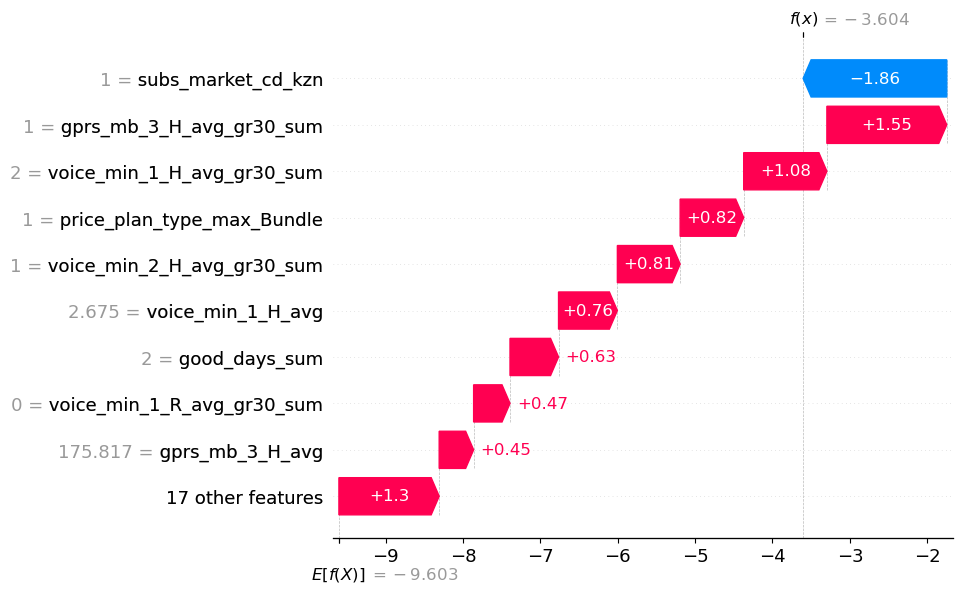

In [17]:
# import shap

explainer = shap.TreeExplainer(clf_lgb)
shap_values = explainer.shap_values(df_pd[model_features])

explanation = shap.Explanation(
    values = shap_values,
    base_values = explainer.expected_value,
    data = df_pd[model_features].values,
    feature_names = model_features
)

shap.plots.waterfall(explanation[0])

In [18]:
def print_shap_explanation_detailed(shap_values, explainer, feature_names, data, instance_idx, threshold=0.001):

    shap_val = shap_values[instance_idx]
    base_value = explainer.expected_value
    actual_values = data.iloc[instance_idx] if hasattr(data, 'iloc') else data[instance_idx]
    
    prediction = base_value + shap_val.sum()
    
    feature_importance = sorted(zip(feature_names, shap_val, actual_values), 
                               key=lambda x: abs(x[1]), reverse=True)
    
    print("="*90)
    print(f"Для наблюдения #{instance_idx}")
    print("="*90)
    print(f"Базовое значение (средний прогноз): {base_value:.4f}")
    print(f"Фактический прогноз: {prediction:.4f}")
    print(f"Сумма SHAP значений: {shap_val.sum():.4f}")
    print("-"*90)
    
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    END = '\033[0m'
    
    strong_impact = [(f, v, a) for f, v, a in feature_importance if abs(v) > 0.1]
    medium_impact = [(f, v, a) for f, v, a in feature_importance if 0.01 <= abs(v) <= 0.1]
    weak_impact = [(f, v, a) for f, v, a in feature_importance if 0.001 <= abs(v) < 0.01]
    
    def print_feature_group(features, title, color):
        if features:
            print(f"\n{color}{BOLD}{title}:{END}")
            print(f"{'Признак':<30} {'Факт.знач':<15} {'Вклад':<12} {'Влияние':<10}")
            print("-"*70)
            for feature, shap_value, actual_value in features:
                if abs(shap_value) > threshold:
                    direction = "↑ УВЕЛИЧ" if shap_value > 0 else "↓ УМЕНЬШ"
                    impact_color = GREEN if shap_value > 0 else RED
                    
                    if isinstance(actual_value, float):
                        actual_str = f"{actual_value:.4f}"
                    else:
                        actual_str = str(actual_value)
                    
                    print(f"{feature:<30} {actual_str:<15} {impact_color}{shap_value:+.4f}{END} {direction:<10}")
    
    print_feature_group(strong_impact, "СИЛЬНОЕ ВЛИЯНИЕ (|вклад| > 0.1)", RED)
    print_feature_group(medium_impact, "СРЕДНЕЕ ВЛИЯНИЕ (0.01 ≤ |вклад| ≤ 0.1)", YELLOW) 
    print_feature_group(weak_impact, "СЛАБОЕ ВЛИЯНИЕ (0.001 ≤ |вклад| < 0.01)", BLUE)
    
    print("-"*90)
    

print_shap_explanation_detailed(shap_values, explainer, model_features, 
                                df_pd[model_features], instance_idx = 0)

#для строки 0 просто выводит значения

Для наблюдения #0
Базовое значение (средний прогноз): -9.6029
Фактический прогноз: -3.6038
Сумма SHAP значений: 5.9991
------------------------------------------------------------------------------------------

СИЛЬНОЕ ВЛИЯНИЕ (|вклад| > 0.1):
Признак                        Факт.знач       Вклад        Влияние   
----------------------------------------------------------------------
subs_market_cd_kzn             1.0000          -1.8561 ↓ УМЕНЬШ  
gprs_mb_3_H_avg_gr30_sum       1.0000          +1.5493 ↑ УВЕЛИЧ  
voice_min_1_H_avg_gr30_sum     2.0000          +1.0751 ↑ УВЕЛИЧ  
price_plan_type_max_Bundle     1.0000          +0.8213 ↑ УВЕЛИЧ  
voice_min_2_H_avg_gr30_sum     1.0000          +0.8112 ↑ УВЕЛИЧ  
voice_min_1_H_avg              2.6750          +0.7603 ↑ УВЕЛИЧ  
good_days_sum                  2.0000          +0.6272 ↑ УВЕЛИЧ  
voice_min_1_R_avg_gr30_sum     0.0000          +0.4701 ↑ УВЕЛИЧ  
gprs_mb_3_H_avg                175.8167        +0.4453 ↑ УВЕЛИЧ  
subs_market_cd_ekt  

In [19]:
def create_shap_summary_df(shap_values, explainer, feature_names, data, client_ids=None, threshold=0.1):

    base_value = explainer.expected_value
    predictions = base_value + np.sum(shap_values, axis=1)
    
    results = []
    
    for instance_idx in range(len(data)):
        shap_val = shap_values[instance_idx]
        actual_values = data.iloc[instance_idx] if hasattr(data, 'iloc') else data[instance_idx]
        
        row_data = {
            'client_id': client_ids[instance_idx] if client_ids is not None else instance_idx,
            'Фактический_прогноз': predictions[instance_idx],
            'Базовое_значение': base_value,
            'Сумма_SHAP_значений': shap_val.sum()
        }
        
        strong_impact_features = []
        for feature, shap_value, actual_value in zip(feature_names, shap_val, actual_values):
            if abs(shap_value) > threshold:
                feature_key = f"{feature}_вклад"
                feature_value_key = f"{feature}_значение"
                row_data[feature_key] = shap_value
                row_data[feature_value_key] = actual_value
                strong_impact_features.append(feature)
        
        row_data['Признаки_с_сильным_влиянием'] = ', '.join(strong_impact_features)
        results.append(row_data)
    
    summary_df = pd.DataFrame(results)
    
    # base_columns = ['id', 'Фактический_прогноз', 'Базовое_значение', 'Сумма_SHAP_значений', 'Признаки_с_сильным_влиянием']
    base_columns = ['Фактический_прогноз', 'Базовое_значение', 'Сумма_SHAP_значений', 'Признаки_с_сильным_влиянием']
    feature_columns = [col for col in summary_df.columns if col not in base_columns]
    
    contribution_cols = [col for col in feature_columns if col.endswith('_вклад')]
    value_cols = [col for col in feature_columns if col.endswith('_значение')]
    
    contribution_cols.sort()
    value_cols.sort()
    
    final_columns = base_columns + contribution_cols + value_cols
    summary_df = summary_df[final_columns]
    
    return summary_df



summary_df = create_shap_summary_df(shap_values, explainer, model_features, 
                                    df_pd[model_features], 
                                    client_ids = df_pd.index)

#для всех значений выведет табл

In [20]:
29 * 2

58

In [21]:
summary_df.columns

Index(['Фактический_прогноз', 'Базовое_значение', 'Сумма_SHAP_значений',
       'Признаки_с_сильным_влиянием', 'accept_days_sum_вклад',
       'active_days_sum_вклад', 'bad_days_sum_вклад', 'calls_sum_вклад',
       'good_days_sum_вклад', 'gprs_mb_3_H_avg_gr30_sum_вклад',
       'gprs_mb_3_H_avg_вклад', 'gprs_mb_3_R_avg_gr30_sum_вклад',
       'price_plan_type_max_Bundle_вклад', 'price_plan_type_max_Data_вклад',
       'price_plan_type_max_Line_вклад', 'price_plan_type_max_Other_вклад',
       'repr2q2025_max_вклад', 'subs_market_cd_ekt_вклад',
       'subs_market_cd_kzn_вклад', 'subs_market_cd_spb_вклад',
       'subs_market_cd_ufa_вклад', 'subs_market_cd_vip_вклад',
       'voice_min_1_H_avg_gr30_sum_вклад', 'voice_min_1_H_avg_вклад',
       'voice_min_1_R_avg_gr30_sum_вклад', 'voice_min_1_R_avg_вклад',
       'voice_min_2_H_avg_gr30_sum_вклад', 'voice_min_2_H_avg_вклад',
       'voice_min_2_R_avg_gr30_sum_вклад', 'voice_min_2_R_avg_вклад',
       'accept_days_sum_значение', 'active_

In [22]:
print(df_pd.shape)

print(summary_df.shape)
summary_df

(1173744, 29)
(1173744, 56)


,Фактический_прогноз,Базовое_значение,Сумма_SHAP_значений,Признаки_с_сильным_влиянием,accept_days_sum_вклад,active_days_sum_вклад,bad_days_sum_вклад,calls_sum_вклад,good_days_sum_вклад,gprs_mb_3_H_avg_gr30_sum_вклад,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
0,-3.603836,-9.60294,5.999104,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,NaN,NaN,NaN,0.627181,1.549298,...,NaN,NaN,2.0,2.675000,0.0,0.000000,1.0,2.363889,0.0,NaN
1,-3.377722,-9.60294,6.225218,"gprs_mb_3_H_avg_gr30_sum, voice_min_1_H_avg_gr...",NaN,NaN,NaN,NaN,0.109041,1.085739,...,NaN,NaN,1.0,NaN,0.0,0.000000,0.0,5.316667,NaN,NaN
2,-6.420716,-9.60294,3.182224,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,-1.310762,NaN,NaN,-5.495513,-20.021800,...,NaN,NaN,0.0,64.730553,NaN,0.000000,1.0,50.508331,0.0,NaN
3,-3.968299,-9.60294,5.634641,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.104994,NaN,NaN,NaN,-1.471366,...,NaN,NaN,1.0,5.086111,0.0,0.000000,1.0,31.597223,1.0,NaN
4,-6.512692,-9.60294,3.090248,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,NaN,NaN,NaN,0.125528,0.231908,...,NaN,NaN,0.0,6.790000,0.0,NaN,2.0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173739,-6.141768,-9.60294,3.461172,"gprs_mb_3_H_avg_gr30_sum, voice_min_1_H_avg_gr...",-0.730351,0.116017,NaN,NaN,0.148604,0.290747,...,NaN,NaN,0.0,0.000000,1.0,4.136111,0.0,0.000000,2.0,7.527778
1173740,-6.192275,-9.60294,3.410665,"gprs_mb_3_H_avg_gr30_sum, voice_min_1_H_avg_gr...",NaN,0.157182,NaN,NaN,0.134619,0.372610,...,NaN,NaN,0.0,0.000000,0.0,0.000000,0.0,0.020000,0.0,NaN
1173741,-6.974402,-9.60294,2.628538,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.100165,NaN,NaN,0.135297,0.544751,...,NaN,NaN,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN
1173742,-6.595257,-9.60294,3.007683,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",0.180254,NaN,0.700039,-47.137666,1.062474,0.689660,...,NaN,NaN,0.0,0.694444,2.0,2.272222,1.0,0.000000,0.0,22.438889


In [23]:
print(df_pd.shape)
print(summary_df.shape)

df_pd_shape = pd.concat([df_pd, summary_df], axis = 1)

print(df_pd_shape.shape)
df_pd_shape.head()

(1173744, 29)
(1173744, 56)
(1173744, 85)


,subscriber_sk,week_of_year,gprs_mb_3_H_avg_gr30_sum,gprs_mb_3_H_avg,voice_min_1_H_avg_gr30_sum,voice_min_1_R_avg,voice_min_2_H_avg_gr30_sum,price_plan_type_max_Other,active_days_sum,price_plan_type_max_Bundle,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
0,70735,42,1,175.816666,2,0.0,1,0,4.0,1,...,NaN,NaN,2.0,2.675000,0.0,0.0,1.0,2.363889,0.0,NaN
1,113379,42,1,166.798340,1,0.0,0,0,3.0,1,...,NaN,NaN,1.0,NaN,0.0,0.0,0.0,5.316667,NaN,NaN
2,114672,42,0,560.145020,0,0.0,1,0,4.0,1,...,NaN,NaN,0.0,64.730553,NaN,0.0,1.0,50.508331,0.0,NaN
3,231762,42,1,923.081665,1,0.0,1,0,4.0,1,...,NaN,NaN,1.0,5.086111,0.0,0.0,1.0,31.597223,1.0,NaN
4,320345,42,0,0.000000,0,0.0,2,0,0.0,1,...,NaN,NaN,0.0,6.790000,0.0,NaN,2.0,0.000000,NaN,NaN


In [24]:
29 + 56

85

##### Sorting

In [25]:
df_pd_shape.sort_values(by = 'score_ML', ascending = False, inplace = True)

print(df_pd_shape.shape)
df_pd_shape

# (1173744, 85)

(1173744, 85)


,subscriber_sk,week_of_year,gprs_mb_3_H_avg_gr30_sum,gprs_mb_3_H_avg,voice_min_1_H_avg_gr30_sum,voice_min_1_R_avg,voice_min_2_H_avg_gr30_sum,price_plan_type_max_Other,active_days_sum,price_plan_type_max_Bundle,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
742792,342859481,42,1,2.963333,0,0.00000,0,1,0.0,0,...,1.0,NaN,0.0,30.047222,0.0,0.00000,0.0,29.227777,2.0,0.452778
730188,262475856,42,1,0.703333,0,0.00000,1,0,0.0,0,...,NaN,0.0,0.0,45.613888,0.0,0.00000,1.0,16.125000,0.0,NaN
383795,211229009,42,0,9.159343,0,0.00000,0,0,1.0,0,...,NaN,0.0,0.0,17.577778,0.0,0.00000,0.0,9.150000,0.0,NaN
477561,227632492,42,0,1194.740356,0,0.47381,0,1,5.0,0,...,NaN,NaN,0.0,0.000000,2.0,0.47381,0.0,0.004762,3.0,0.821429
56659,337013797,42,1,2.196667,0,0.00000,0,0,1.0,0,...,NaN,0.0,0.0,22.825001,0.0,0.00000,0.0,45.577778,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132177,257924609,42,1,76.813332,0,0.00000,1,0,4.0,0,...,NaN,NaN,0.0,15.333333,0.0,0.00000,1.0,12.644444,1.0,NaN
132168,257440156,42,0,61.755207,0,0.00000,1,0,1.0,0,...,NaN,0.0,0.0,61.033333,0.0,0.00000,1.0,15.786111,0.0,NaN
165229,57476027,42,0,837.429993,1,0.00000,1,0,4.0,0,...,NaN,1.0,1.0,26.200001,0.0,NaN,1.0,37.069447,0.0,NaN
927505,16434558,42,0,43.996666,1,0.00000,0,0,0.0,0,...,NaN,NaN,1.0,6.527778,0.0,NaN,0.0,24.258333,NaN,NaN


In [26]:
df_pd_shape.columns

Index(['subscriber_sk', 'week_of_year', 'gprs_mb_3_H_avg_gr30_sum',
       'gprs_mb_3_H_avg', 'voice_min_1_H_avg_gr30_sum', 'voice_min_1_R_avg',
       'voice_min_2_H_avg_gr30_sum', 'price_plan_type_max_Other',
       'active_days_sum', 'price_plan_type_max_Bundle', 'voice_min_2_H_avg',
       'voice_min_2_R_avg_gr30_sum', 'voice_min_1_H_avg', 'good_days_sum',
       'accept_days_sum', 'bad_days_sum', 'voice_min_1_R_avg_gr30_sum',
       'repr2q2025_max', 'subs_market_cd_vip', 'voice_min_2_R_avg',
       'price_plan_type_max_Line', 'subs_market_cd_ekt',
       'gprs_mb_3_R_avg_gr30_sum', 'subs_market_cd_kzn',
       'price_plan_type_max_Data', 'subs_market_cd_ufa', 'subs_market_cd_spb',
       'calls_sum', 'score_ML', 'Фактический_прогноз', 'Базовое_значение',
       'Сумма_SHAP_значений', 'Признаки_с_сильным_влиянием',
       'accept_days_sum_вклад', 'active_days_sum_вклад', 'bad_days_sum_вклад',
       'calls_sum_вклад', 'good_days_sum_вклад',
       'gprs_mb_3_H_avg_gr30_sum_вклад',

In [27]:
df_pd_shape = df_pd_shape[['subscriber_sk', 'week_of_year', 'score_ML',
       # 'gprs_mb_3_H_avg_gr30_sum',
       # 'gprs_mb_3_H_avg', 'voice_min_1_H_avg_gr30_sum', 'voice_min_1_R_avg',
       # 'voice_min_2_H_avg_gr30_sum', 'price_plan_type_max_Other',
       # 'active_days_sum', 'price_plan_type_max_Bundle', 'voice_min_2_H_avg',
       # 'voice_min_2_R_avg_gr30_sum', 'voice_min_1_H_avg', 'good_days_sum',
       # 'accept_days_sum', 'bad_days_sum', 'voice_min_1_R_avg_gr30_sum',
       # 'repr2q2025_max', 'subs_market_cd_vip', 'voice_min_2_R_avg',
       # 'price_plan_type_max_Line', 'subs_market_cd_ekt',
       # 'gprs_mb_3_R_avg_gr30_sum', 'subs_market_cd_kzn',
       # 'price_plan_type_max_Data', 'subs_market_cd_ufa', 'subs_market_cd_spb',
       # 'calls_sum', 
       # 'Фактический_прогноз', 'Базовое_значение',
       'Сумма_SHAP_значений', 'Признаки_с_сильным_влиянием',
       'accept_days_sum_вклад', 'active_days_sum_вклад', 'bad_days_sum_вклад',
       'calls_sum_вклад', 'good_days_sum_вклад',
       'gprs_mb_3_H_avg_gr30_sum_вклад', 'gprs_mb_3_H_avg_вклад',
       'gprs_mb_3_R_avg_gr30_sum_вклад', 'price_plan_type_max_Bundle_вклад',
       'price_plan_type_max_Data_вклад', 'price_plan_type_max_Line_вклад',
       'price_plan_type_max_Other_вклад', 'repr2q2025_max_вклад',
       'subs_market_cd_ekt_вклад', 'subs_market_cd_kzn_вклад',
       'subs_market_cd_spb_вклад', 'subs_market_cd_ufa_вклад',
       'subs_market_cd_vip_вклад', 'voice_min_1_H_avg_gr30_sum_вклад',
       'voice_min_1_H_avg_вклад', 'voice_min_1_R_avg_gr30_sum_вклад',
       'voice_min_1_R_avg_вклад', 'voice_min_2_H_avg_gr30_sum_вклад',
       'voice_min_2_H_avg_вклад', 'voice_min_2_R_avg_gr30_sum_вклад',
       'voice_min_2_R_avg_вклад', 'accept_days_sum_значение',
       'active_days_sum_значение', 'bad_days_sum_значение',
       'calls_sum_значение', 'good_days_sum_значение',
       'gprs_mb_3_H_avg_gr30_sum_значение', 'gprs_mb_3_H_avg_значение',
       'gprs_mb_3_R_avg_gr30_sum_значение',
       'price_plan_type_max_Bundle_значение',
       'price_plan_type_max_Data_значение',
       'price_plan_type_max_Line_значение',
       'price_plan_type_max_Other_значение', 'repr2q2025_max_значение',
       'subs_market_cd_ekt_значение', 'subs_market_cd_kzn_значение',
       'subs_market_cd_spb_значение', 'subs_market_cd_ufa_значение',
       'subs_market_cd_vip_значение', 'voice_min_1_H_avg_gr30_sum_значение',
       'voice_min_1_H_avg_значение', 'voice_min_1_R_avg_gr30_sum_значение',
       'voice_min_1_R_avg_значение', 'voice_min_2_H_avg_gr30_sum_значение',
       'voice_min_2_H_avg_значение', 'voice_min_2_R_avg_gr30_sum_значение',
       'voice_min_2_R_avg_значение']]

print(df_pd_shape.shape)
df_pd_shape.head()

# (1173744, 85)

(1173744, 57)


,subscriber_sk,week_of_year,score_ML,Сумма_SHAP_значений,Признаки_с_сильным_влиянием,accept_days_sum_вклад,active_days_sum_вклад,bad_days_sum_вклад,calls_sum_вклад,good_days_sum_вклад,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
742792,342859481,42,1.0,237.798671,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.598934,0.451802,NaN,NaN,-0.526549,...,1.0,NaN,0.0,30.047222,0.0,0.00000,0.0,29.227777,2.0,0.452778
730188,262475856,42,1.0,40.431206,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",0.280935,NaN,2.422003,NaN,-0.239913,...,NaN,0.0,0.0,45.613888,0.0,0.00000,1.0,16.125000,0.0,NaN
383795,211229009,42,1.0,41.744543,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.187762,-2.114221,NaN,2.057272,...,NaN,0.0,0.0,17.577778,0.0,0.00000,0.0,9.150000,0.0,NaN
477561,227632492,42,1.0,79.222988,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",0.697599,10.310596,NaN,0.273244,-0.391604,...,NaN,NaN,0.0,0.000000,2.0,0.47381,0.0,0.004762,3.0,0.821429
56659,337013797,42,1.0,40.218859,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",0.311196,0.170284,NaN,NaN,2.298119,...,NaN,0.0,0.0,22.825001,0.0,0.00000,0.0,45.577778,0.0,NaN


<Axes: >

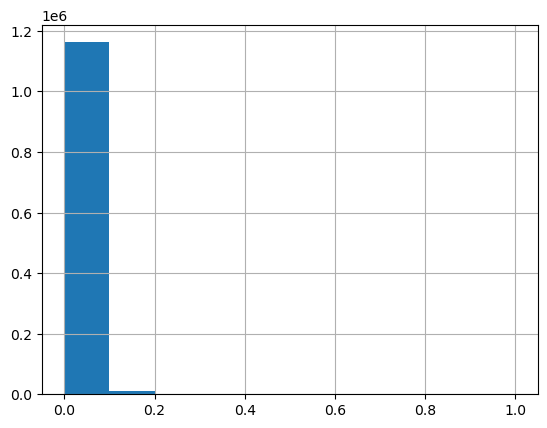

In [28]:
df_pd_shape['score_ML'].hist(bins = 10)

<Axes: >

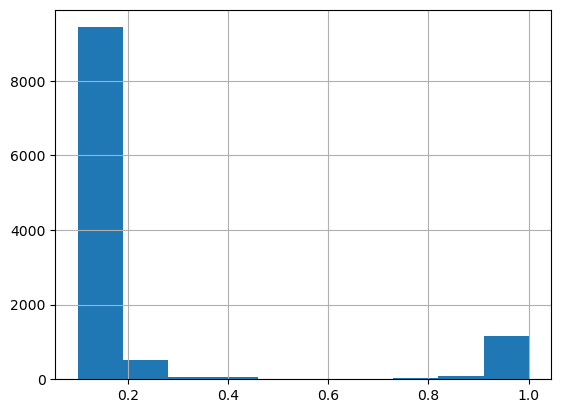

In [33]:
df_pd_shape[df_pd_shape['score_ML'] > 0.1]['score_ML'].hist(bins = 10)

<Axes: >

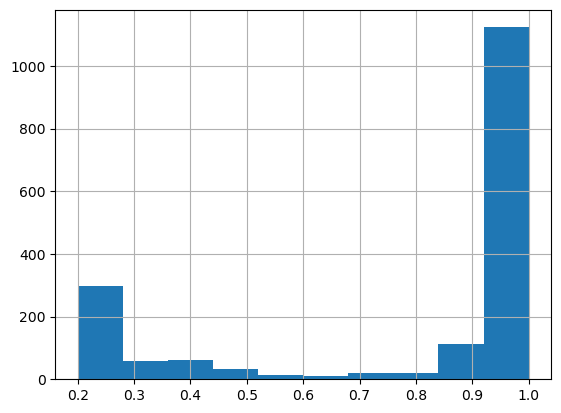

In [36]:
df_pd_shape[df_pd_shape['score_ML'] > 0.2]['score_ML'].hist(bins = 10)

In [29]:
# 1 - входящий;
# 2 - исходящий;

df_top_ml_300 = df_pd_shape.iloc[:300, :]

df_top_ml_300 = df_top_ml_300.reset_index(drop = True)

print(df_top_ml_300.shape)
df_top_ml_300.head()

(300, 57)


,subscriber_sk,week_of_year,score_ML,Сумма_SHAP_значений,Признаки_с_сильным_влиянием,accept_days_sum_вклад,active_days_sum_вклад,bad_days_sum_вклад,calls_sum_вклад,good_days_sum_вклад,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
0,342859481,42,1.0,237.798671,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.598934,0.451802,NaN,NaN,-0.526549,...,1.0,NaN,0.0,30.047222,0.0,0.00000,0.0,29.227777,2.0,0.452778
1,262475856,42,1.0,40.431206,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",0.280935,NaN,2.422003,NaN,-0.239913,...,NaN,0.0,0.0,45.613888,0.0,0.00000,1.0,16.125000,0.0,NaN
2,211229009,42,1.0,41.744543,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.187762,-2.114221,NaN,2.057272,...,NaN,0.0,0.0,17.577778,0.0,0.00000,0.0,9.150000,0.0,NaN
3,227632492,42,1.0,79.222988,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",0.697599,10.310596,NaN,0.273244,-0.391604,...,NaN,NaN,0.0,0.000000,2.0,0.47381,0.0,0.004762,3.0,0.821429
4,337013797,42,1.0,40.218859,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",0.311196,0.170284,NaN,NaN,2.298119,...,NaN,0.0,0.0,22.825001,0.0,0.00000,0.0,45.577778,0.0,NaN


In [121]:
dict_vars = {'gprs_mb_3_H_avg_gr30_sum': 'Домашний дата трафик (тригер падения на 30%)',
                'gprs_mb_3_H_avg': 'Домашний дата трафик ',
                'voice_min_1_H_avg_gr30_sum': 'Домашний входящий голосовой трафик (тригер падения на 30%)',
                'voice_min_1_R_avg': 'Роуминговый входящий голосовой трафик ',
                'voice_min_2_H_avg_gr30_sum': 'Домашний исходящий голосовой трафик (тригер падения на 30%)',
                'price_plan_type_max_Other': 'Тип тарифного плана ("Other")',
                'active_days_sum': 'Кол-во активных дней',
                'price_plan_type_max_Bundle': 'Тип тарифного плана ("Bundle")',
                'voice_min_2_H_avg': 'Домашний исходящий голосовой трафик',
                'voice_min_2_R_avg_gr30_sum': 'Роуминговый исходящий голосовой трафик (тригер падения на 30%)',
                'voice_min_1_H_avg': 'Домашний входящий голосовой трафик ',
                'good_days_sum': 'Кол-во хороших дней (качество интернет сети)',
                'accept_days_sum': 'Кол-во приемлемых дней (качество интернет сети)',
                'bad_days_sum': 'Кол-во плохих дней (качество интернет сети)',
                'voice_min_1_R_avg_gr30_sum': 'Роуминговый входящий голосовой трафик  (тригер падения на 30%)',
                'repr2q2025_max': 'Флаг попадания в репрайс во 2 квартале 2025 года',
                'subs_market_cd_vip': 'Регион (Москва)',
                'voice_min_2_R_avg': 'Роуминговый исходящий голосовой трафик ',
                'price_plan_type_max_Line': 'Тип тарифного плана ("Line")',
                'subs_market_cd_ekt': 'Регион (Екатеринбург)',
                'gprs_mb_3_R_avg_gr30_sum': 'Роуминговый дата трафик (тригер падения на 30%)',
                'subs_market_cd_kzn': 'Регион (Казань)',
                'price_plan_type_max_Data': 'Тип тарифного плана ("Data")',
                'subs_market_cd_ufa': 'Регион (Уфа)',
                'subs_market_cd_spb': 'Регион (СПБ)',
                'calls_sum': 'Кол-во звонков'
            }

In [122]:
# df_top_ml_300.info()

In [129]:
vars_cons = ['accept_days_sum_вклад', 'active_days_sum_вклад', 'bad_days_sum_вклад',
               'calls_sum_вклад', 'good_days_sum_вклад',
               'gprs_mb_3_H_avg_gr30_sum_вклад', 'gprs_mb_3_H_avg_вклад',
               'gprs_mb_3_R_avg_gr30_sum_вклад', 'price_plan_type_max_Bundle_вклад',
               'price_plan_type_max_Data_вклад', 'price_plan_type_max_Line_вклад',
               'price_plan_type_max_Other_вклад', 'repr2q2025_max_вклад',
               'subs_market_cd_ekt_вклад', 'subs_market_cd_kzn_вклад',
               'subs_market_cd_spb_вклад', 'subs_market_cd_ufa_вклад',
               'subs_market_cd_vip_вклад', 'voice_min_1_H_avg_gr30_sum_вклад',
               'voice_min_1_H_avg_вклад', 'voice_min_1_R_avg_gr30_sum_вклад',
               'voice_min_1_R_avg_вклад', 'voice_min_2_H_avg_gr30_sum_вклад',
               'voice_min_2_H_avg_вклад', 'voice_min_2_R_avg_gr30_sum_вклад',
               'voice_min_2_R_avg_вклад']

list_sk = list(df_top_ml_300['subscriber_sk'])
rows = []
n = 0

# for i in [342859481]:
# for i in [342859481, 262475856, 211229009]:
for i in list_sk:

    vars_top5 = pd.DataFrame(df_top_ml_300[df_top_ml_300['subscriber_sk'] == i][vars_cons].T, columns = [n])
    vars_top5 = vars_top5.sort_values(n, ascending = False)
    # print(vars_top5)
    n += 1
    
    vars_top5 = list(vars_top5[:5].index)

    vars_top5_str = ''
    for j in range(5):
        var = vars_top5[j][:-6]
        var = dict_vars.get(var, var)
        # vars_top5_str += var + ', '
        if j < 4:
            vars_top5_str += var + ', '
        else:
            vars_top5_str += var
    
    row = {
        'subscriber_sk': i,
        'top_5_признаков_с_сильным_влиянием': vars_top5_str
    }
    rows.append(row)

# Convert to DataFrame after the loop
df_top5 = pd.DataFrame(rows)
df_top5

,subscriber_sk,top_5_признаков_с_сильным_влиянием
0,342859481,"Домашний дата трафик (тригер падения на 30%), ..."
1,262475856,"Домашний входящий голосовой трафик , Домашний ..."
2,211229009,"Домашний входящий голосовой трафик , Домашний ..."
3,227632492,"Домашний дата трафик , Кол-во активных дней, Д..."
4,337013797,"Домашний входящий голосовой трафик , Домашний ..."
...,...,...
295,507706773,Кол-во приемлемых дней (качество интернет сети...
296,289507454,"Домашний входящий голосовой трафик , Роумингов..."
297,297464779,"Роуминговый входящий голосовой трафик , Домашн..."
298,537472810,"Тип тарифного плана (""Line""), Роуминговый вход..."


In [130]:
df_top_ml_300['top_5_признаков_с_сильным_влиянием'] = df_top5['top_5_признаков_с_сильным_влиянием']

print(df_top_ml_300.shape)
df_top_ml_300.head(3)

(300, 58)


,subscriber_sk,week_of_year,score_ML,Сумма_SHAP_значений,top_5_признаков_с_сильным_влиянием,Признаки_с_сильным_влиянием,accept_days_sum_вклад,active_days_sum_вклад,bad_days_sum_вклад,calls_sum_вклад,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
0,342859481,42,1.0,237.798671,"Домашний дата трафик (тригер падения на 30%), ...","gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.598934,0.451802,NaN,NaN,...,1.0,NaN,0.0,30.047222,0.0,0.0,0.0,29.227777,2.0,0.452778
1,262475856,42,1.0,40.431206,"Домашний входящий голосовой трафик , Домашний ...","gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",0.280935,NaN,2.422003,NaN,...,NaN,0.0,0.0,45.613888,0.0,0.0,1.0,16.125000,0.0,NaN
2,211229009,42,1.0,41.744543,"Домашний входящий голосовой трафик , Домашний ...","gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.187762,-2.114221,NaN,...,NaN,0.0,0.0,17.577778,0.0,0.0,0.0,9.150000,0.0,NaN


In [131]:
df_top_ml_300.columns

Index(['subscriber_sk', 'week_of_year', 'score_ML', 'Сумма_SHAP_значений',
       'top_5_признаков_с_сильным_влиянием', 'Признаки_с_сильным_влиянием',
       'accept_days_sum_вклад', 'active_days_sum_вклад', 'bad_days_sum_вклад',
       'calls_sum_вклад', 'good_days_sum_вклад',
       'gprs_mb_3_H_avg_gr30_sum_вклад', 'gprs_mb_3_H_avg_вклад',
       'gprs_mb_3_R_avg_gr30_sum_вклад', 'price_plan_type_max_Bundle_вклад',
       'price_plan_type_max_Data_вклад', 'price_plan_type_max_Line_вклад',
       'price_plan_type_max_Other_вклад', 'repr2q2025_max_вклад',
       'subs_market_cd_ekt_вклад', 'subs_market_cd_kzn_вклад',
       'subs_market_cd_spb_вклад', 'subs_market_cd_ufa_вклад',
       'subs_market_cd_vip_вклад', 'voice_min_1_H_avg_gr30_sum_вклад',
       'voice_min_1_H_avg_вклад', 'voice_min_1_R_avg_gr30_sum_вклад',
       'voice_min_1_R_avg_вклад', 'voice_min_2_H_avg_gr30_sum_вклад',
       'voice_min_2_H_avg_вклад', 'voice_min_2_R_avg_gr30_sum_вклад',
       'voice_min_2_R_avg_вкла

In [132]:
df_top_ml_300 = df_top_ml_300[['subscriber_sk', 'week_of_year', 'score_ML', 'Сумма_SHAP_значений',
                               'top_5_признаков_с_сильным_влиянием',
                               'Признаки_с_сильным_влиянием', 'accept_days_sum_вклад',
                               'active_days_sum_вклад', 'bad_days_sum_вклад', 'calls_sum_вклад',
                               'good_days_sum_вклад', 'gprs_mb_3_H_avg_gr30_sum_вклад',
                               'gprs_mb_3_H_avg_вклад', 'gprs_mb_3_R_avg_gr30_sum_вклад',
                               'price_plan_type_max_Bundle_вклад', 'price_plan_type_max_Data_вклад',
                               'price_plan_type_max_Line_вклад', 'price_plan_type_max_Other_вклад',
                               'repr2q2025_max_вклад', 'subs_market_cd_ekt_вклад',
                               'subs_market_cd_kzn_вклад', 'subs_market_cd_spb_вклад',
                               'subs_market_cd_ufa_вклад', 'subs_market_cd_vip_вклад',
                               'voice_min_1_H_avg_gr30_sum_вклад', 'voice_min_1_H_avg_вклад',
                               'voice_min_1_R_avg_gr30_sum_вклад', 'voice_min_1_R_avg_вклад',
                               'voice_min_2_H_avg_gr30_sum_вклад', 'voice_min_2_H_avg_вклад',
                               'voice_min_2_R_avg_gr30_sum_вклад', 'voice_min_2_R_avg_вклад',
                               'accept_days_sum_значение', 'active_days_sum_значение',
                               'bad_days_sum_значение', 'calls_sum_значение', 'good_days_sum_значение',
                               'gprs_mb_3_H_avg_gr30_sum_значение', 'gprs_mb_3_H_avg_значение',
                               'gprs_mb_3_R_avg_gr30_sum_значение',
                               'price_plan_type_max_Bundle_значение',
                               'price_plan_type_max_Data_значение',
                               'price_plan_type_max_Line_значение',
                               'price_plan_type_max_Other_значение', 'rep r2q2025_max_значение',
                               'subs_market_cd_ekt_значение', 'subs_market_cd_kzn_значение',
                               'subs_market_cd_spb_значение', 'subs_market_cd_ufa_значение',
                               'subs_market_cd_vip_значение', 'voice_min_1_H_avg_gr30_sum_значение',
                               'voice_min_1_H_avg_значение', 'voice_min_1_R_avg_gr30_sum_значение',
                               'voice_min_1_R_avg_значение', 'voice_min_2_H_avg_gr30_sum_значение',
                               'voice_min_2_H_avg_значение', 'voice_min_2_R_avg_gr30_sum_значение',
                               'voice_min_2_R_avg_значение']]

In [133]:
print(df_top_ml_300.shape)
df_top_ml_300.head(3)

(300, 58)


,subscriber_sk,week_of_year,score_ML,Сумма_SHAP_значений,top_5_признаков_с_сильным_влиянием,Признаки_с_сильным_влиянием,accept_days_sum_вклад,active_days_sum_вклад,bad_days_sum_вклад,calls_sum_вклад,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
0,342859481,42,1.0,237.798671,"Домашний дата трафик (тригер падения на 30%), ...","gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.598934,0.451802,NaN,NaN,...,1.0,NaN,0.0,30.047222,0.0,0.0,0.0,29.227777,2.0,0.452778
1,262475856,42,1.0,40.431206,"Домашний входящий голосовой трафик , Домашний ...","gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",0.280935,NaN,2.422003,NaN,...,NaN,0.0,0.0,45.613888,0.0,0.0,1.0,16.125000,0.0,NaN
2,211229009,42,1.0,41.744543,"Домашний входящий голосовой трафик , Домашний ...","gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.187762,-2.114221,NaN,...,NaN,0.0,0.0,17.577778,0.0,0.0,0.0,9.150000,0.0,NaN


<Axes: >

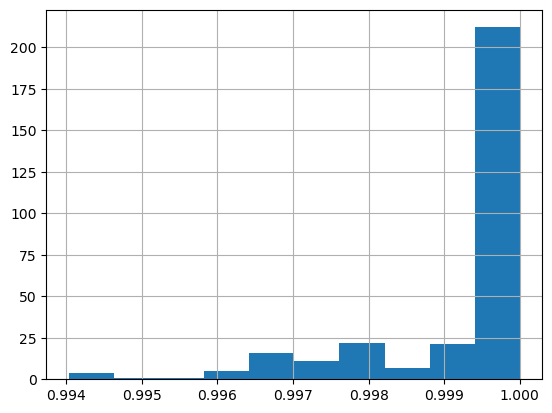

In [138]:
df_top_ml_300['score_ML'].hist()

In [137]:
# df_top_ml_300.to_excel('df_top_ml_300_features_shape_v3.xlsx')

In [135]:
# # df_top_ml_300['top_5_признаков_с_сильным_влиянием'] = df_top_ml_300['top5_признаков_с_сильным_влиянием'].map(dict_vars)

# for i in range(300):
#     rus_top_5 = []
#     eng_top_5 = df_top_ml_300.loc[i, 'top5_признаков_с_сильным_влиянием']
    
#     for j in range(5):
#         # rus_top_5 += eng_top_5[i].map(dict_vars)
#         # print(eng_top_5)

# print(df_top_ml_300.shape)
# df_top_ml_300.head(3)

In [95]:
model_features

['gprs_mb_3_H_avg_gr30_sum',
 'gprs_mb_3_H_avg',
 'voice_min_1_H_avg_gr30_sum',
 'voice_min_1_R_avg',
 'voice_min_2_H_avg_gr30_sum',
 'price_plan_type_max_Other',
 'active_days_sum',
 'price_plan_type_max_Bundle',
 'voice_min_2_H_avg',
 'voice_min_2_R_avg_gr30_sum',
 'voice_min_1_H_avg',
 'good_days_sum',
 'accept_days_sum',
 'bad_days_sum',
 'voice_min_1_R_avg_gr30_sum',
 'repr2q2025_max',
 'subs_market_cd_vip',
 'voice_min_2_R_avg',
 'price_plan_type_max_Line',
 'subs_market_cd_ekt',
 'gprs_mb_3_R_avg_gr30_sum',
 'subs_market_cd_kzn',
 'price_plan_type_max_Data',
 'subs_market_cd_ufa',
 'subs_market_cd_spb',
 'calls_sum']

In [75]:
# *****************************************************************************************************************************************

#### LogReg

In [15]:
# ********* read model (aggregation logreg): *****************
import pickle
with open('model_logreg_aggregate.pkl', 'rb') as fid:
    
    log_reg = pickle.load(fid)

print(log_reg.coef_, log_reg.intercept_)
# [[-0.00173262  0.01152435]] [-7.60430242]

[[-0.00173262  0.01152435]] [-7.60430242]


In [16]:
X = df_pd[['preds_trig_model', 'score_ML']]

In [17]:
# df_pd.drop('score_final', axis = 1, inplace = True)

(1173744, 27)
(1173744, 28)
(1173744, 1)


array([[<Axes: title={'center': 'score_final_log'}>]], dtype=object)

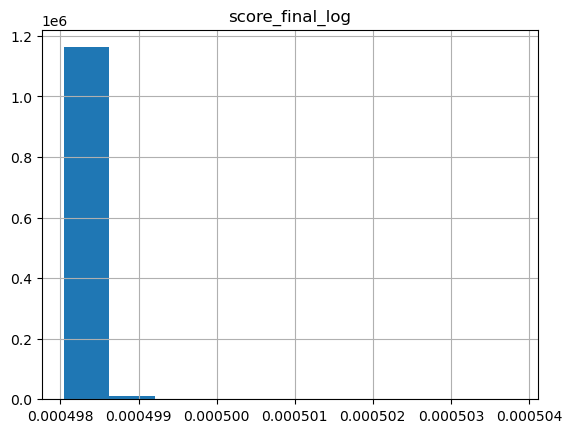

In [18]:
y_pred_log = log_reg.predict_proba(X)[:,1]

y_pred_log_pd = pd.DataFrame(y_pred_log).rename(columns = {0: 'score_final_log'})

print(df_pd.shape)
df_pd['score_final_log'] = y_pred_log_pd
print(df_pd.shape)

print(y_pred_log_pd.shape)
y_pred_log_pd.hist()

In [19]:
y_pred_log_pd.describe()

,score_final_log
count,1.173744e+06
mean,4.981496e-04
std,2.264422e-07
min,4.980499e-04
25%,4.980646e-04
50%,4.980810e-04
75%,4.981771e-04
max,5.038247e-04


In [20]:
df_pd = df_pd.sort_values(by = 'score_final_log', ascending = False)
print(df_pd.shape)
df_pd

(1173744, 28)


,subscriber_sk,week_of_year,woe_calls_sum_ratio_mean_lag0_2_4,woe_voice_min_2_HR_avg_ratio_mean_lag0_2_4,woe_voice_min_1_HR_avg_ratio_mean_lag0_2_4,woe_gprs_mb_3_HR_avg_relative_change_lag0_1,woe_voice_min_1to2_HR_avg_relative_change_lag0_1,preds_trig_model,interp_woe_calls_sum_ratio_mean_lag0_2_4,interp_woe_voice_min_2_HR_avg_ratio_mean_lag0_2_4,...,segment_cd,subscriber_status_cd,nice_number_flg,test_price_plan_flg,test_ban_flg,test_account_flg,subscriber_base_flg,agent_service_flg,score_ML,score_final_log
554054,534051253,42,-0.006622,-0.312108,-0.870836,-1.115118,0.202256,0.000077,Отсутствие обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,SH,A,1,0,0,0,1,0,1.000000e+00,0.000504
1010887,476181932,42,-0.006622,-0.312108,-0.406228,-1.115118,-0.275938,0.000087,Отсутствие обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,SH,A,0,0,0,0,1,0,1.000000e+00,0.000504
1011153,512074816,42,-0.006622,-0.312108,-0.870836,-0.415085,0.202256,0.000116,Отсутствие обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,SH,A,0,0,0,0,1,0,1.000000e+00,0.000504
386486,512420054,42,-0.006622,-0.312108,-0.406228,-0.415085,-0.343407,0.000125,Отсутствие обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,SH,A,0,0,0,0,1,0,1.000000e+00,0.000504
826857,558044946,42,-0.006622,-0.312108,-0.406228,-0.376009,-0.275938,0.000135,Отсутствие обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,SH,A,0,0,0,0,1,0,1.000000e+00,0.000504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339466,305920699,42,1.444656,-0.580575,0.300669,0.731767,0.202256,0.004138,Рост количества обращений в последние 4 недели,Рост исх. голосового траффика в последние 4 не...,...,KA,A,0,0,0,0,1,0,1.839027e-04,0.000498
116043,84492459,42,1.444656,-0.312108,0.300669,0.731767,-0.275938,0.003529,Рост количества обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,ME,A,0,0,0,0,1,0,7.004260e-11,0.000498
906901,7163989,42,1.444656,0.282380,0.300669,0.731767,0.202256,0.008077,Рост количества обращений в последние 4 недели,Отсутствие исх. голосового траффика в последни...,...,ME,A,0,0,0,0,1,0,5.403050e-04,0.000498
144143,180725283,42,1.444656,-0.191628,0.300669,0.731767,0.202256,0.005596,Рост количества обращений в последние 4 недели,Падение исх. голосового трафика в последние 4 ...,...,SE,A,0,0,0,0,1,0,7.594746e-05,0.000498


In [23]:
# df_pd_1500 = df_pd.iloc[:1500, :]
df_pd_1500 = df_pd.iloc[:300, :]
df_pd_1500[['preds_trig_model', 'score_ML', 'score_final_log']].describe()

,preds_trig_model,score_ML,score_final_log
count,300.000000,300.000000,3.000000e+02
mean,0.000253,0.999262,5.038203e-04
std,0.000127,0.001269,7.361169e-09
min,0.000077,0.994037,5.037900e-04
25%,0.000232,0.999173,5.038198e-04
50%,0.000253,1.000000,5.038245e-04
75%,0.000265,1.000000,5.038246e-04
max,0.001647,1.000000,5.038247e-04


In [24]:
df_pd_1500['score_final_log']

554054     0.000504
1010887    0.000504
1011153    0.000504
386486     0.000504
826857     0.000504
             ...   
96105      0.000504
444960     0.000504
497614     0.000504
914955     0.000504
697664     0.000504
Name: score_final_log, Length: 300, dtype: float64

In [26]:
print(df_pd_1500.shape)
df_pd_1500.head()

(300, 28)


,subscriber_sk,week_of_year,woe_calls_sum_ratio_mean_lag0_2_4,woe_voice_min_2_HR_avg_ratio_mean_lag0_2_4,woe_voice_min_1_HR_avg_ratio_mean_lag0_2_4,woe_gprs_mb_3_HR_avg_relative_change_lag0_1,woe_voice_min_1to2_HR_avg_relative_change_lag0_1,preds_trig_model,interp_woe_calls_sum_ratio_mean_lag0_2_4,interp_woe_voice_min_2_HR_avg_ratio_mean_lag0_2_4,...,segment_cd,subscriber_status_cd,nice_number_flg,test_price_plan_flg,test_ban_flg,test_account_flg,subscriber_base_flg,agent_service_flg,score_ML,score_final_log
554054,534051253,42,-0.006622,-0.312108,-0.870836,-1.115118,0.202256,0.000077,Отсутствие обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,SH,A,1,0,0,0,1,0,1.0,0.000504
1010887,476181932,42,-0.006622,-0.312108,-0.406228,-1.115118,-0.275938,0.000087,Отсутствие обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,SH,A,0,0,0,0,1,0,1.0,0.000504
1011153,512074816,42,-0.006622,-0.312108,-0.870836,-0.415085,0.202256,0.000116,Отсутствие обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,SH,A,0,0,0,0,1,0,1.0,0.000504
386486,512420054,42,-0.006622,-0.312108,-0.406228,-0.415085,-0.343407,0.000125,Отсутствие обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,SH,A,0,0,0,0,1,0,1.0,0.000504
826857,558044946,42,-0.006622,-0.312108,-0.406228,-0.376009,-0.275938,0.000135,Отсутствие обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,SH,A,0,0,0,0,1,0,1.0,0.000504


In [27]:
# df_pd_1500.to_excel('df_log_score.xlsx')

In [ ]:
# ***************************************************************************************************************************************

In [28]:
# X = df_pd[['preds_trig_model', 'score_ML']]

In [29]:
df_pd[['preds_trig_model', 'score_ML']]

,preds_trig_model,score_ML
554054,0.000077,1.000000e+00
1010887,0.000087,1.000000e+00
1011153,0.000116,1.000000e+00
386486,0.000125,1.000000e+00
826857,0.000135,1.000000e+00
...,...,...
339466,0.004138,1.839027e-04
116043,0.003529,7.004260e-11
906901,0.008077,5.403050e-04
144143,0.005596,7.594746e-05


In [30]:
df_pd['week_of_year'].value_counts()

42    1173744
Name: week_of_year, dtype: int64

<Axes: >

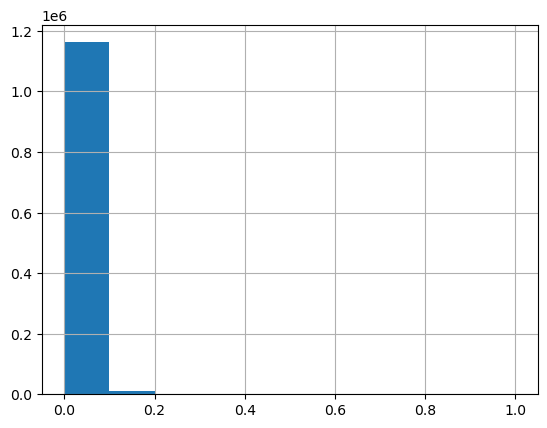

In [31]:
df_pd['score_ML'].hist()

<Axes: >

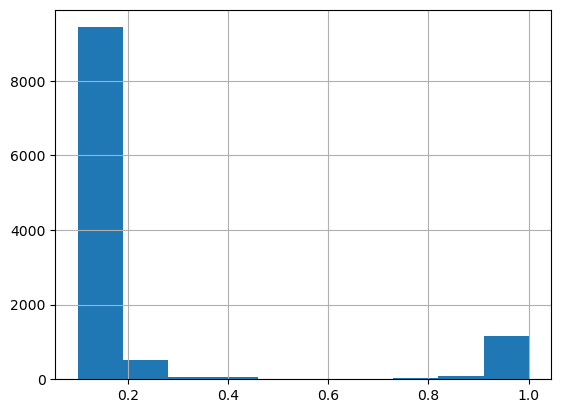

In [32]:
df_pd[df_pd['score_ML'] > 0.1]['score_ML'].hist()

<Axes: >

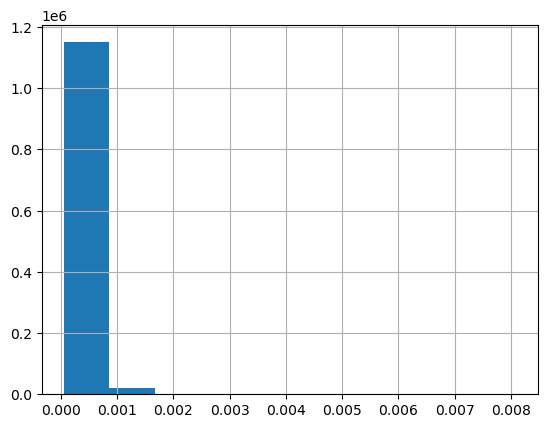

In [33]:
df_pd['preds_trig_model'].hist()

In [34]:
df_pd['preds_trig_model'].describe()

count    1.173744e+06
mean     2.956945e-04
std      1.934582e-04
min      6.264955e-05
25%      2.265479e-04
50%      2.550236e-04
75%      2.787531e-04
max      8.077094e-03
Name: preds_trig_model, dtype: float64

In [35]:
df_top_trig = df_pd[['subscriber_sk', 'preds_trig_model']].sort_values(by = 'preds_trig_model', ascending = False).iloc[:1500,:]

df_top_ml = df_pd[['subscriber_sk', 'score_ML']].sort_values(by = 'score_ML', ascending = False).iloc[:1500,:]

len( set(df_top_trig['subscriber_sk']).intersection(set(df_top_ml['subscriber_sk'])) )

15

In [62]:
num = 45639

df_top_trig = df_pd[['subscriber_sk', 'preds_trig_model']].sort_values(by = 'preds_trig_model', ascending = False).iloc[:num,:]

df_top_ml = df_pd[['subscriber_sk', 'score_ML']].sort_values(by = 'score_ML', ascending = False).iloc[:num,:]

common_sk = list( set(df_top_trig['subscriber_sk']).intersection(set(df_top_ml['subscriber_sk'])) )

len( common_sk )

301

In [64]:
df_pd_out = df_pd[df_pd['subscriber_sk'].isin(common_sk)]

df_pd_out.drop('score_final_log', axis = 1, inplace = True)
print(df_pd_out.shape)
df_pd_out.head(3)

(301, 27)


/tmp/ipykernel_2989/2166119671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd_out.drop('score_final_log', axis = 1, inplace = True)


,subscriber_sk,week_of_year,woe_calls_sum_ratio_mean_lag0_2_4,woe_voice_min_2_HR_avg_ratio_mean_lag0_2_4,woe_voice_min_1_HR_avg_ratio_mean_lag0_2_4,woe_gprs_mb_3_HR_avg_relative_change_lag0_1,woe_voice_min_1to2_HR_avg_relative_change_lag0_1,preds_trig_model,interp_woe_calls_sum_ratio_mean_lag0_2_4,interp_woe_voice_min_2_HR_avg_ratio_mean_lag0_2_4,...,churn_flg,segment_cd,subscriber_status_cd,nice_number_flg,test_price_plan_flg,test_ban_flg,test_account_flg,subscriber_base_flg,agent_service_flg,score_ML
808056,443746390,42,1.444656,0.282380,-0.870836,-1.115118,0.202256,0.000799,Рост количества обращений в последние 4 недели,Отсутствие исх. голосового траффика в последни...,...,0,LA,A,0,0,0,0,1,0,1.000000
913279,402900140,42,1.444656,-0.312108,0.216917,-1.115118,-0.343407,0.001047,Рост количества обращений в последние 4 недели,Исх. голосовой траффик в допустимых пределах в...,...,0,KA,A,0,0,0,0,1,0,0.999872
132301,578100843,42,-0.006622,0.282380,0.300669,0.731767,0.202256,0.001249,Отсутствие обращений в последние 4 недели,Отсутствие исх. голосового траффика в последни...,...,0,SH,A,0,0,0,0,1,0,0.999874


In [65]:
# df_pd_out.to_excel('df_inter_score.xlsx')

In [68]:
len( set(df_pd_1500['subscriber_sk']).intersection(set(df_pd_out['subscriber_sk'])) )

4